(ak chces aj data, napis mi na mail a spristupnim ti - stano.hrivnak@gmail.com)

# Machine Learning approach - Save the vineyard!

<img src="vineyard.jpeg" width="600" height="700">

<h3><center>Model popisujuci realitu by mal byt tak jednoduchy ako sa len da. Ale nie jednoduchsi. (Einstein)</center></h3>

## Data preprocessing

### Nacitanie datasetu

In [76]:
import os
import cv2
import matplotlib.pyplot as plt
from skimage.io import imread
import numpy as np

def read_images(path, downsample=4):
    print('Reading from', path)
    files = [file for file in os.listdir(path) if file.endswith('.JPG')]
    image = imread(path + files[0])
    print('Original resolution:', image.shape)
    new_height = image.shape[0]//downsample
    new_width = image.shape[1]//downsample
    images = np.zeros(shape=(len(files), new_height, new_width, image.shape[2]))
    for i, file in enumerate(files):
        image = cv2.resize(imread(path + file), (new_width, new_height), interpolation=cv2.INTER_AREA)
        images[i, :,:,:] = image[:, :new_width, :]
        
    print('New resolution:', images[0].shape)
    return images.astype(np.uint8)

zdrave = read_images(path='zdrave/')
esca = read_images(path='esca/')
suche = read_images(path='suche/')

Reading from ../EmbedMeet_ZA/zdrave/
Original resolution: (2160, 3840, 3)
New resolution: (540, 960, 3)
Reading from ../EmbedMeet_ZA/esca/
Original resolution: (2160, 3840, 3)
New resolution: (540, 960, 3)
Reading from ../EmbedMeet_ZA/suche/
Original resolution: (2160, 3840, 3)
New resolution: (540, 960, 3)


### Mnozstvo obrazkov

<IPython.core.display.Javascript object>


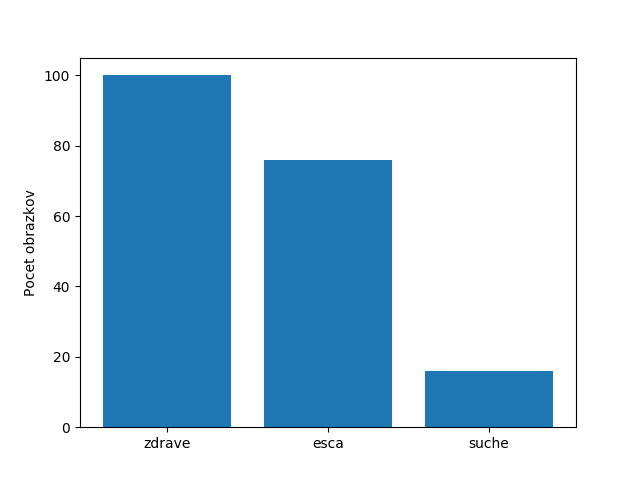

In [77]:
%matplotlib notebook
plt.figure(0)
plt.bar(['zdrave', 'esca', 'suche'], [zdrave.shape[0], esca.shape[0], suche.shape[0]])
plt.ylabel('Pocet obrazkov')
plt.show()

### Ukazky obrazkov

<IPython.core.display.Javascript object>


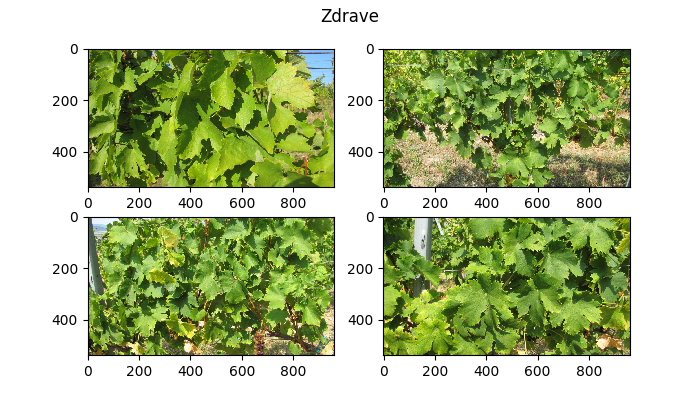

<IPython.core.display.Javascript object>


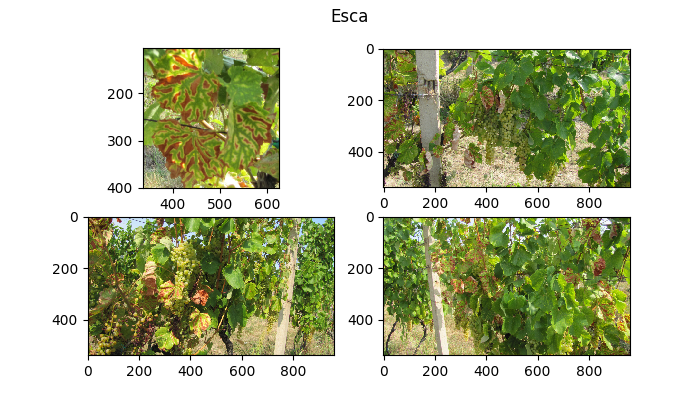

<IPython.core.display.Javascript object>


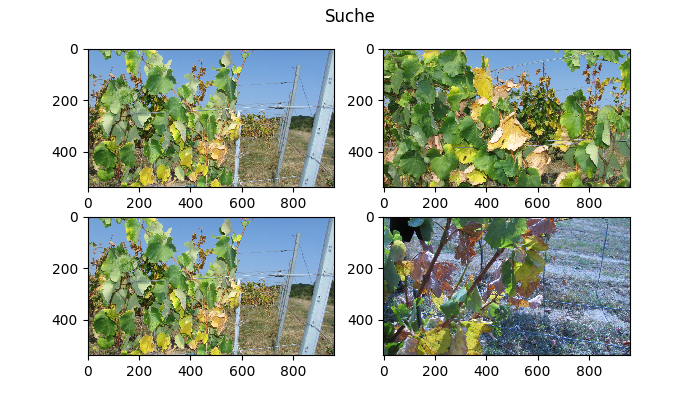

In [78]:
def random_image_sample(img_list, title=''):
    rnd_nbs = np.random.randint(len(img_list), size=4)
    fig = plt.figure(figsize=(7,4))
    fig.add_subplot(221)
    plt.imshow(img_list[rnd_nbs[0]])
    fig.add_subplot(222)
    plt.imshow(img_list[rnd_nbs[1]])
    fig.add_subplot(223)
    plt.imshow(img_list[rnd_nbs[2]])
    fig.add_subplot(224)
    plt.imshow(img_list[rnd_nbs[3]])
    plt.suptitle(title)
    plt.show()
    
random_image_sample(zdrave, title='Zdrave')
random_image_sample(esca, title='Esca')
random_image_sample(suche, title='Suche')

<IPython.core.display.Javascript object>


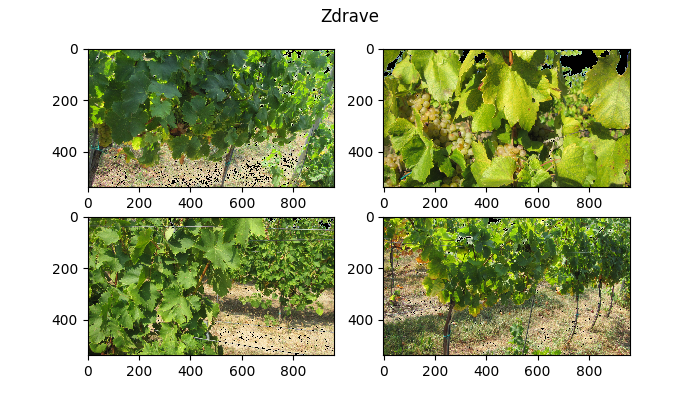

<IPython.core.display.Javascript object>


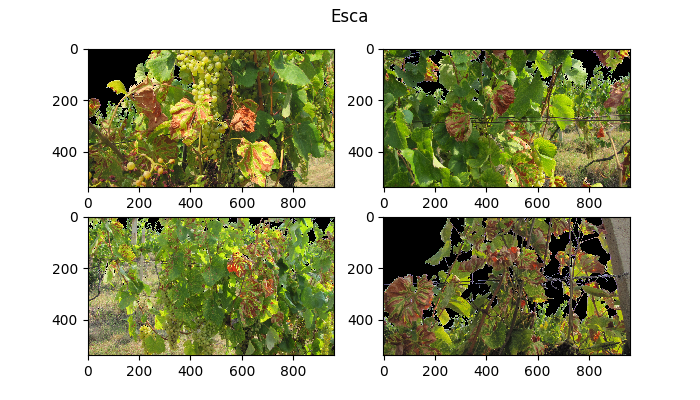

<IPython.core.display.Javascript object>


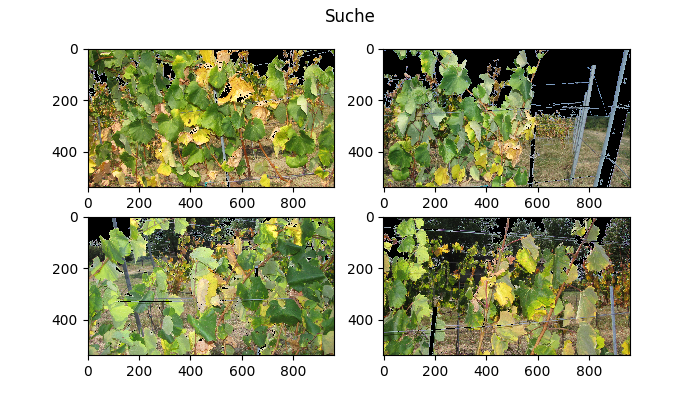

In [79]:
def erase_sky(img_array):
    img_array[img_array[:,:,:,2] > (0.8 * 255)] = 0
    return img_array

random_image_sample(erase_sky(zdrave), title='Zdrave')
random_image_sample(erase_sky(esca), title='Esca')
random_image_sample(erase_sky(suche), title='Suche')

### Farebna segmentacia

<IPython.core.display.Javascript object>


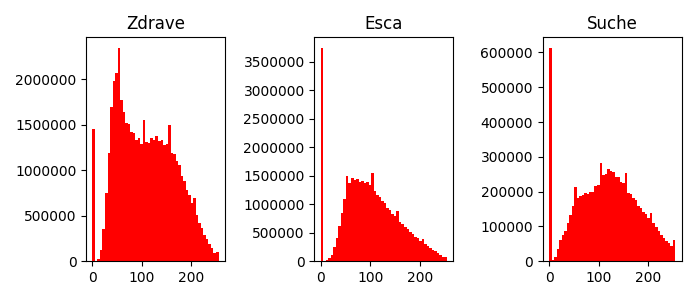

<IPython.core.display.Javascript object>


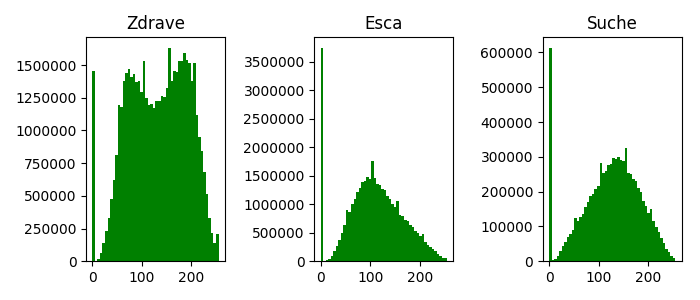

<IPython.core.display.Javascript object>


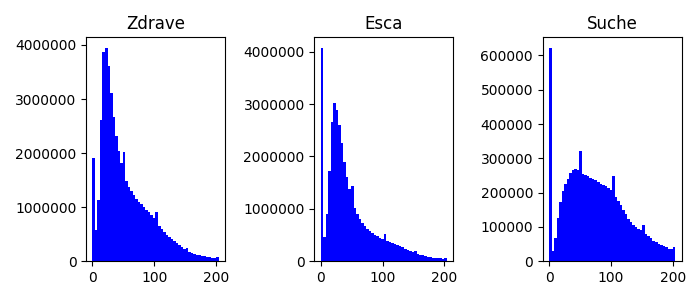

In [81]:
colors = {0: 'r', 1: 'g', 2: 'b'}
for channel, color in colors.items():
    fig2 = plt.figure(figsize=(7, 3))
    fig2.add_subplot(131)
    plt.hist(zdrave[:,:,:,channel].ravel(), bins=50, color=color)
    plt.title('Zdrave')
    fig2.add_subplot(132)
    plt.hist(esca[:,:,:,channel].ravel(), bins=50, color=color)
    plt.title('Esca')
    fig2.add_subplot(133)
    plt.hist(suche[:,:,:,channel].ravel(), bins=50, color=color)
    plt.title('Suche')
    fig2.tight_layout()
    plt.show()

<IPython.core.display.Javascript object>


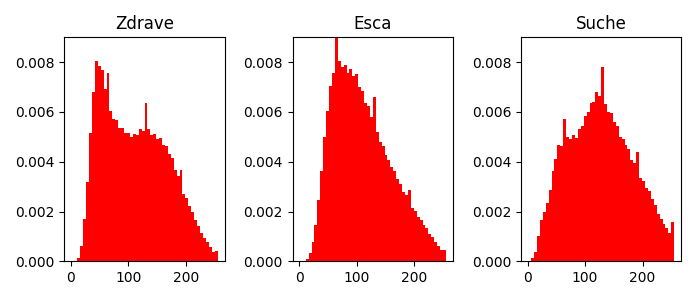

<IPython.core.display.Javascript object>


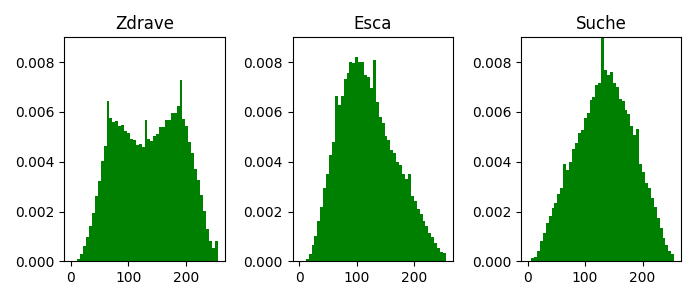

<IPython.core.display.Javascript object>


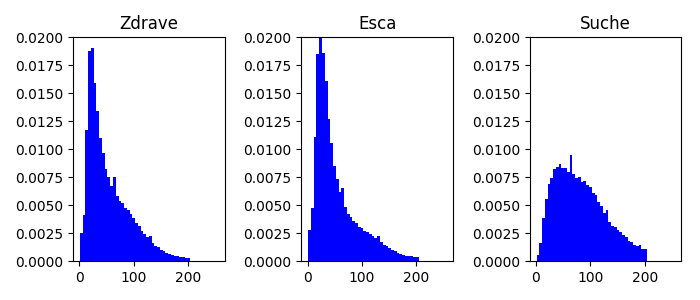

In [83]:
def plot_hists(nbins=50, val_range=(0,255)):
    colors = {0: 'r', 1: 'g', 2: 'b'}
    for channel, color in colors.items():
        if color in ['r', 'g']:
            ymax = 0.009
        else:
            ymax = 0.02
        fig2 = plt.figure(figsize=(7, 3))
        fig2.add_subplot(131)
        plt.hist(zdrave[:,:,:,channel].ravel(), bins=nbins, color=color, density=True, range=val_range)
        plt.ylim(0,ymax)
        plt.title('Zdrave')
        fig2.add_subplot(132)
        plt.hist(esca[:,:,:,channel].ravel(), bins=nbins, color=color, density=True, range=val_range)
        plt.ylim(0,ymax)
        plt.title('Esca')
        fig2.add_subplot(133)
        plt.hist(suche[:,:,:,channel].ravel(), bins=nbins, color=color, density=True, range=val_range)
        plt.ylim(0,ymax)
        plt.title('Suche')
        fig2.tight_layout()
        plt.show()

plot_hists(val_range=(1, 255))

<IPython.core.display.Javascript object>


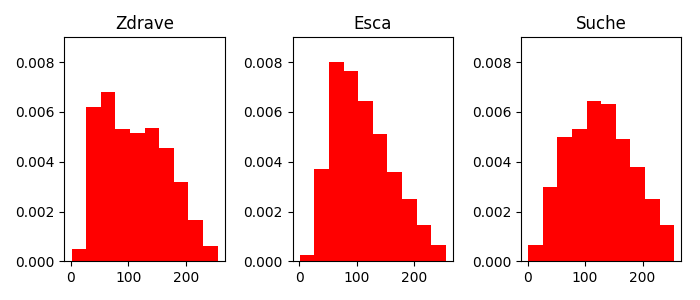

<IPython.core.display.Javascript object>


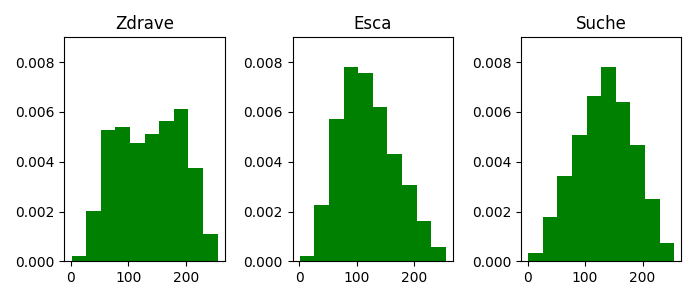

<IPython.core.display.Javascript object>


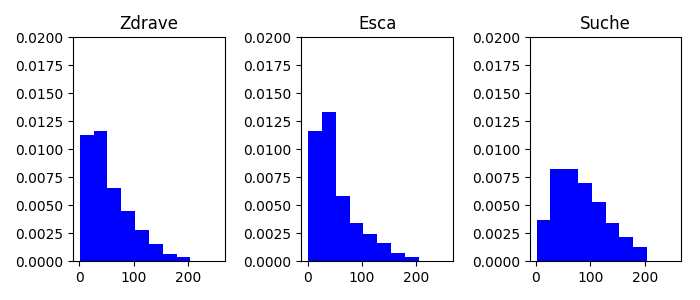

In [84]:
# create histograms for all images (10 bins)
plot_hists(nbins=10, val_range=(1,255))

## Tvorba modelu

In [85]:
import pandas as pd

data = pd.DataFrame(columns=['hist_data', 'label'])
def append_to_df(img_array, df, label):
    for image in img_array:
        hist_r = np.histogram(image[:,:,0], bins=10, density=True, range=(1,255))[0]
        hist_g = np.histogram(image[:,:,1], bins=10, density=True, range=(1,255))[0]
        hist_b = np.histogram(image[:,:,2], bins=10, density=True, range=(1,255))[0]
        hist = np.append(np.append(hist_r, hist_g), hist_b)
        df = df.append({'hist_data': hist, 'label': label}, ignore_index=True)
    return df

data = append_to_df(zdrave, data, 0)
data = append_to_df(esca, data, 1)
data = append_to_df(suche, data, 2)
data

hist_data label
0    [0.0006257419009951361, 0.01879665747821456, 0...     0
1    [0.00020312435266682166, 0.00966820866876569, ...     0
2    [0.0001462759324875245, 0.006808486761858828, ...     0
3    [8.371064072263284e-05, 0.007957602944491313, ...     0
4    [0.0002206234967420703, 0.005922947796523227, ...     0
5    [0.0002560016083827808, 0.010146569579300725, ...     0
6    [0.00012617540888197257, 0.007333292942654781,...     0
7    [0.0005648343472284483, 0.006698510114594659, ...     0
8    [0.00013124517625725352, 0.004907179937213853,...     0
9    [1.634915458275183e-05, 0.0033051582354980207,...     0
10   [0.0002742830465610879, 0.0059161445588063995,...     0
11   [0.00011373403470899983, 0.005371928090697951,...     0
12   [0.00017572908042924756, 0.010949013291206733,...     0
13   [9.210883358715458e-06, 0.005149881643219135, ...     0
14   [2.8912666399872547e-05, 0.006414777369631139,...     0
15   [0.00014450228623496742, 0.004273340259500255,...     0
16   [0.00031998775655456724, 0.008470830485953696,...     0
17   [0.00046100531747516514, 0.010602171953635652,...     0
18   [4.579509005273938e-05, 0.0045640581401083175,...     0
19   [2.2330862936217486e-05, 0.004049253074073498,...     0
20   [0.00021396317630828233, 0.006698950176278475,...     0
21   [0.00011604781584523735, 0.006427814608714729,...     0
22   [0.0004805212917752672, 0.006269192449580649, ...     0
23   [8.186600586825287e-05, 0.005240186628881669, ...     0
24   [0.0005059156864331917, 0.007152266685277649, ...     0
25   [9.178383804733796e-06, 0.001532710283357459, ...     0
26   [3.281462614816265e-05, 0.0007649706659985046,...     0
27   [3.709199685525004e-05, 0.0008751901892138753,...     0
28   [1.78128639254992e-05, 0.0009281805485472315, ...     0
29   [0.00010288702623576843, 0.0020846832507312226...     0
..                                                 ...   ...
162  [0.0003560935666157092, 0.004247643019020165, ...     1
163  [0.000368721183108326, 0.00471882739188879, 0....     1
164  [0.0002892112439249939, 0.0031143919381522913,...     1
165  [0.00028736015091042767, 0.005539504199455754,...     1
166  [8.475025588694397e-05, 0.003041633370172425, ...     1
167  [0.0011921176096900109, 0.010290779954235827, ...     1
168  [4.937749374563893e-05, 0.003335167285118258, ...     1
169  [8.220230486990925e-05, 0.003351510325178187, ...     1
170  [0.00037073333214458515, 0.002202886452675585,...     1
171  [0.00040777695782251184, 0.002085832526011573,...     1
172  [0.0001397813353976596, 0.003196763901552358, ...     1
173  [0.00021779777536451794, 0.005481697758705711,...     1
174  [8.122431369709158e-05, 0.004339552736544031, ...     1
175  [5.0517570183753854e-05, 0.0031509450541051818...     1
176  [0.001857642653987791, 0.005193625102117193, 0...     2
177  [0.0008104131223621824, 0.003697978430768657, ...     2
178  [7.679048901974668e-05, 0.002022487027742192, ...     2
179  [0.00013954858917294933, 0.0019898113148445664...     2
180  [0.000226235380121542, 0.0035353578833457596, ...     2
181  [0.0002711885876018694, 0.002829861449331471, ...     2
182  [0.00011988935634533252, 0.0021541298944204854...     2
183  [0.00018207875419893032, 0.003116554361763441,...     2
184  [0.00016505286962871377, 0.0035164247660091617...     2
185  [0.00010087665980534585, 0.001657045915511517,...     2
186  [2.7148936496165045e-05, 0.0011350841068396623...     2
187  [0.00025603471451418126, 0.002644664750199415,...     2
188  [0.0009237382902199411, 0.00334989082973032, 0...     2
189  [0.0006713730386760467, 0.0022724796870834374,...     2
190  [0.001735451706843211, 0.003897452161008407, 0...     2
191  [0.002632475318248575, 0.0045192862083984695, ...     2

[192 rows x 2 columns]

### Decision tree

In [86]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split

X = np.stack(data['hist_data'].values)
y = data['label'].values.astype(int)
dtc = DecisionTreeClassifier(max_depth=2)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
dtc.fit(X_train, y_train)
# print(dtc.score(X_test, y_test))

res = cross_validate(dtc, X, y, cv=10, return_train_score=True)
print(res)
print(res['test_score'].mean(), '+-', res['test_score'].std())

{'fit_time': array([0.00113702, 0.00110483, 0.00108576, 0.00107503, 0.00115728,
       0.00112581, 0.001091  , 0.001086  , 0.0010879 , 0.00109792]), 'score_time': array([0.00025797, 0.00019717, 0.00020027, 0.00032616, 0.00024295,
       0.00019622, 0.00019288, 0.00019312, 0.00019217, 0.00019526]), 'test_score': array([0.7       , 0.75      , 0.85      , 0.95      , 0.85      ,
       0.75      , 1.        , 0.88888889, 0.88888889, 0.94444444]), 'train_score': array([0.94767442, 0.9244186 , 0.93023256, 0.91860465, 0.9244186 ,
       0.9244186 , 0.9137931 , 0.92528736, 0.9137931 , 0.9137931 ])}
0.8572222222222223 +- 0.0929638851953665


<img src="1fXzj.png">
<caption><center> <u>Figure 1</u>: Cross-validation explained. <br> </center></caption>

<img src="overfit.png">
<caption><center> <u>Figure 2</u>: Underfit and overfit explained. <br> </center></caption>

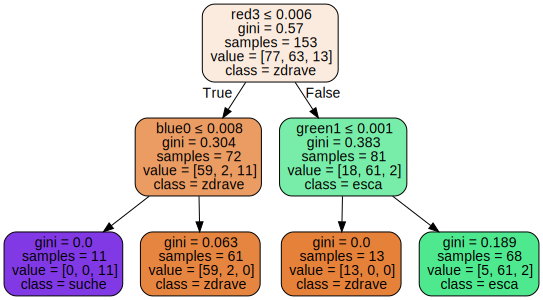

In [87]:
import graphviz

feature_names = ['red0', 'red1', 'red2', 'red3', 'red4', 'red5', 'red6', 'red7', 'red8', 'red9',
                'green0' ,'green1','green2','green3','green4','green5','green6','green7','green8','green9',
                'blue0','blue1','blue2','blue3','blue4','blue5','blue6','blue7','blue8','blue9']
dot_data = export_graphviz(dtc, out_file=None, feature_names=feature_names,  
                           class_names=['zdrave', 'esca', 'suche'],
                           filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(dot_data)
graph

Different metrics for Decision trees determining the quality of a split:

1. Impurity measure:
$$ I = \frac{\text{# of misclassified}}{\text{# of samples}} $$

2. Information entropy:
$$ H = - \sum_i \sum_y p_i(y) \log p_i(y) $$

3. Gini index:
$$ G = \sum_i \sum_y p_i(y) (1 - p_i(y)) $$

### K-nearest neighbours

In [88]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)

res = cross_validate(knn, X, y, cv=10, return_train_score=True)
print(res)
print(res['test_score'].mean(), '+-', res['test_score'].std())

{'fit_time': array([0.00494003, 0.00035119, 0.00035882, 0.00032783, 0.00032425,
       0.00041413, 0.0003469 , 0.00034094, 0.00034022, 0.00035501]), 'score_time': array([0.00221491, 0.00082898, 0.00064206, 0.00066423, 0.0006938 ,
       0.00068784, 0.00069904, 0.00066781, 0.00067091, 0.00072503]), 'test_score': array([0.75      , 0.75      , 1.        , 1.        , 0.75      ,
       1.        , 1.        , 0.77777778, 1.        , 0.94444444]), 'train_score': array([0.96511628, 0.96511628, 0.95348837, 0.95348837, 0.96511628,
       0.95348837, 0.95402299, 0.95977011, 0.93678161, 0.95402299])}
0.8972222222222224 +- 0.11590358913902814


### PCA to visualize

In [89]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
X_t = pca.fit_transform(X)

print(pca.explained_variance_ratio_)

[0.33848517 0.2966773  0.13736301]


<IPython.core.display.Javascript object>


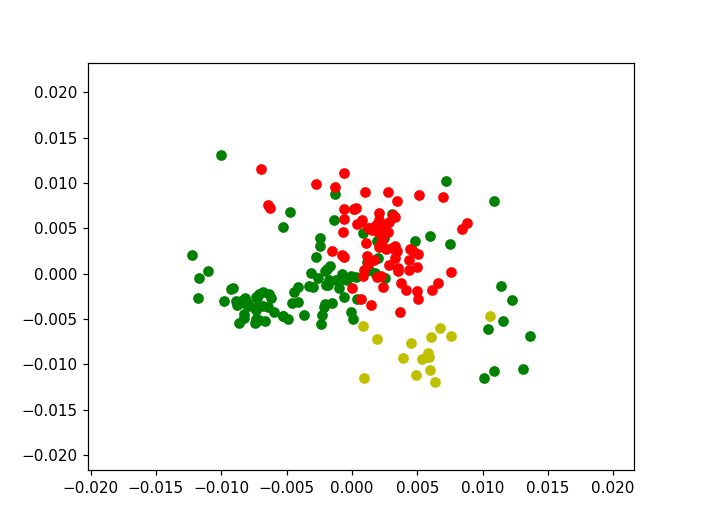

In [90]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
color = ['g', 'r', 'y']
for cl in range(3):
    data = X_t[y == cl]
    plt.scatter(data[:,0], data[:,1], c=color[cl])

<IPython.core.display.Javascript object>


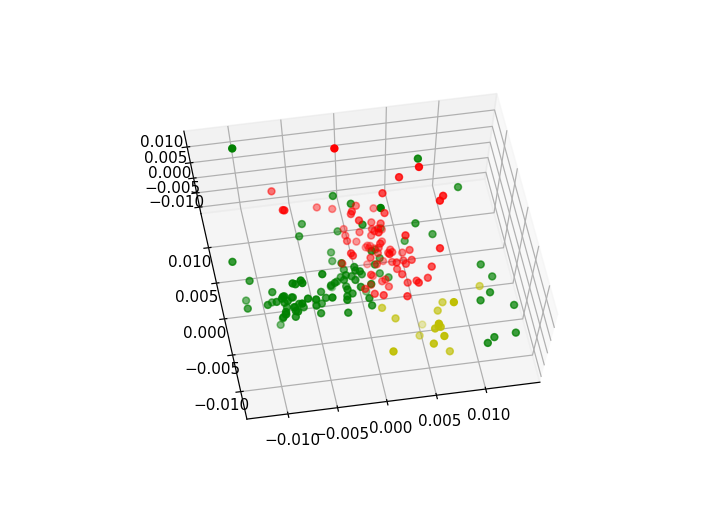

In [91]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
color = ['g', 'r', 'y']
for cl in range(3):
    data = X_t[y == cl]
    ax.scatter(data[:,0], data[:,1], data[:,2], c=color[cl])

### Random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth=5, n_estimators=10)
res = cross_validate(rf, X, y, cv=10, return_train_score=True)
print(res)
print(res['test_score'].mean(), '+-', res['test_score'].std())

## Evaluacia modelu

### Confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = dtc.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure()
heatmap = sns.heatmap(conf_mat, annot=True, fmt="d")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.xticks(np.arange(4)+0.5, ('zdrave', 'esca', 'suche'))
plt.yticks(np.arange(4)+0.5, ('zdrave', 'esca', 'suche'))
plt.show()

## Klasifikacia zdrave - nezdrave (binarne)

In [ ]:
y_bin = y.copy()
y_bin[y_bin != 0] = 1
y_bin

In [ ]:
dtc2 = DecisionTreeClassifier(max_depth=3)

res2 = cross_validate(dtc2, X, y_bin, cv=10, return_train_score=True)
print(res2)
print(res2['test_score'].mean(), '+-', res2['test_score'].std())

In [ ]:
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(X, y_bin, test_size=0.2)

dtc2.fit(X_train_bin, y_train_bin)
y_pred_bin = dtc2.predict(X_test_bin)
conf_mat = confusion_matrix(y_test_bin, y_pred_bin)
plt.figure()
heatmap = sns.heatmap(conf_mat, annot=True, fmt="d")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.xticks(np.arange(2)+0.5, ('zdrave', 'nezdrave'))
plt.yticks(np.arange(2)+0.5, ('zdrave', 'nezdrave'))
plt.show()

### Precision vs. Recall

\begin{equation}
    recall = \frac{\mathrm{kolko \, nezdravych\, sme\, trafili}}{\mathrm{kolko\, nezdravych\, tam\, bolo}} \\
    precision = \frac{\mathrm{kolko\, nezdravych\, sme\, trafili}}{\mathrm{kolko\, nezdravych\, sme\, urcili}}
\end{equation}

In [ ]:
from sklearn.metrics import recall_score, precision_score, precision_recall_curve

print('Recall:', recall_score(y_test_bin, y_pred_bin))
print('Precision:', precision_score(y_test_bin, y_pred_bin))

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test_bin, lr2.predict_proba(X_test_bin)[:,1])

plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve')
plt.show()